# **Personal Loan Acceptance**

Universal Bank is a relatively young bank growing rapidly in terms of overall customer acquisition. The majority of these customers are liability customers (depositors) with varying sizes of relationship with the bank. The customer base of asset customers (borrowers) is quite small, and **the bank is interested in expanding this base rapidly to bring in more loan business.** In particular, it wants to explore ways of converting its depositors to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for depositors showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise smarter campaigns with better target marketing. **The goal is to use
k-NN to predict whether a new customer will accept a loan offer.** This will serve as the basis for the design of a new campaign.

The file _UniversalBank.csv_ contains data on 5000 customers. The data include customer demographic information (age, income, etc.), the customer’s relationship with the bank (mortgage, securities account, etc.), and the customer response to the last personal loan campaign (Personal Loan). Among these 5000 customers, only 480 (= 9.6%) accepted the personal loan that was offered to them in the earlier campaign.

## Preprocessing

In [1]:
# import required packages
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# connect to Google Drive and load the data
# from google.colab import drive
# drive.mount('/content/drive')
bank_df = pd.read_csv('../data/UniversalBank.csv')
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


The variable we are interested in predicting is called "Personal Loan", which is a binary variable, 0 means the customer did not accept the loan offer, 1 means the customer accepted the loan offer.

In [3]:
# drop ID and ZIP Code columns
bank_df = bank_df.drop(columns=['ID', 'ZIP Code'])

# make sure that the result is as expected
bank_df.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1


In [6]:
# modify column names, replacing empty spaces with _
bank_df.columns = [x.replace(' ', '_') for x in bank_df.columns]
list(bank_df.columns)

['Age',
 'Experience',
 'Income',
 'Family',
 'CCAvg',
 'Education',
 'Mortgage',
 'Personal_Loan',
 'Securities_Account',
 'CD_Account',
 'Online',
 'CreditCard']

In [7]:
# create dummy variables for categorical variables
# consider Education as categorical variable
bank_df['Education'] = bank_df['Education'].astype('category')
bank_df = pd.get_dummies(bank_df, prefix_sep='_', drop_first=False)
bank_df.head()

,Age,Experience,Income,Family,CCAvg,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Education_1,Education_2,Education_3
0,25,1,49,4,1.6,0,0,1,0,0,0,1,0,0
1,45,19,34,3,1.5,0,0,1,0,0,0,1,0,0
2,39,15,11,1,1.0,0,0,0,0,0,0,1,0,0
3,35,9,100,1,2.7,0,0,0,0,0,0,0,1,0
4,35,8,45,4,1.0,0,0,0,0,0,1,0,1,0


In [8]:
# Separate X (input features/aka predictors) from y (target)
outcome = 'Personal_Loan'
predictors = list(bank_df.columns)
predictors.remove(outcome)

# Store predictors and target into X and y, respectively
X = bank_df[predictors]
y = bank_df[outcome]

In [9]:
# split dataset into training (60%) and test (40%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.4, random_state=2, stratify=y)
print('Training set:', X_train.shape, 'Testing set:', X_test.shape)

# Note, the 'stratify' option ensures that both the y training and y testing data
# have the same proportion of 1's and 0's. For instance, if y_train has
# 10% of entries that are 1 and 90% that are 0, then the stratify option will
# ensure that the y_test data also has 10% 1's and 90% 0's

Training set: (3000, 13) Testing set: (2000, 13)


In [10]:
# Standardize training and testing features using 'StandatdScaler()'
# (a slightly different method than what we did in the PCA lab)

# the first line defines the scaling object
scaler = preprocessing.StandardScaler()

# the second line specifies which data to use to compute means and variances
scaler.fit(X_train)
# important: in this step, you should fit the scaler only to training data, 
# and not the testing data. We assume testing data is never available to us
# in the training stage

# the third line scales the data using the means and variances computed in the
# previous step
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Note, there is no need to scale the target y variable, since this is what
# we are trying to predict

## Run the k-NN Model!

In [18]:
# Run the k-NN model with a random guess about the neighboors, set k=1 for instance
knn = KNeighborsClassifier(n_neighbors=1)
# Specify the training features (X_train) and the outcome they lead to (y_train)
# Important: only use the training data at this step. Do not use test data.
knn.fit(X_train_scaled, y_train)

# Now that the model is done, we can use it to predict whether the new customers
# from the testing data, will accept a loan or not. For this, we feed the
# testing features X_test into the prediction function.
y_pred = knn.predict(X_test_scaled)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.9615


In [19]:
# Choosing the best k for the test set
# train a classifier for different "odd" values of k
# using a 'for' loop and range(start, stop, step)
results = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train_scaled, y_train)
    
    # create a dictionary to store the results
    results.append({
        'k': k,
        'accuracy': accuracy_score(y_test, knn.predict(X_test_scaled))
    })

# convert results to a pandas dataframe for better visualization
results_df = pd.DataFrame(results)
results_df

,k,accuracy
0,1,0.9615
1,3,0.9665
2,5,0.9625
3,7,0.9630
4,9,0.9595
5,11,0.9580
6,13,0.9555
7,15,0.9545
8,17,0.9530
9,19,0.9505


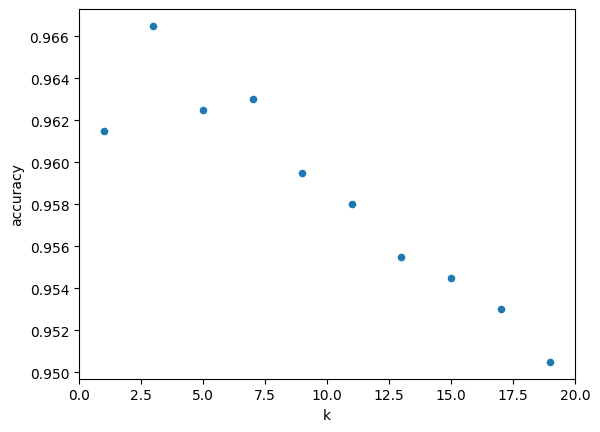

In [20]:
# plot accuracy vs. k
results_df.plot.scatter(x='k', y='accuracy', xlim=[0, 20]);

We choose the best k, which minimizes the misclassification rate in the validation set. Our best k is `k=3`

In [22]:
# Show the confusion matrix and accuracy for the test data, using k = 3
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

pred_y = knn.predict(X_test_scaled)
print(confusion_matrix(y_test, pred_y))
print('Accuracy:', accuracy_score(y_test, pred_y))

[[1798   10]
 [  57  135]]
Accuracy: 0.9665


## Bonus: Let's now create a new customer that the model has never seen before...

In [23]:
# We will get the column names to help
list(bank_df.columns)

['Age',
 'Experience',
 'Income',
 'Family',
 'CCAvg',
 'Mortgage',
 'Personal_Loan',
 'Securities_Account',
 'CD_Account',
 'Online',
 'CreditCard',
 'Education_1',
 'Education_2',
 'Education_3']

In [24]:
# define a new customer (remove Personal_Loan column)
newCustomer = pd.DataFrame([
{
 'Age':60,
 'Experience':20,
 'Income':110,
 'Family':4,
 'CCAvg':2,
 'Mortgage':0,
 'Securities_Account':0,
 'CD_Account':0,
 'Online':1,
 'CreditCard':1,
 'Education_1':0,
 'Education_2':1,
 'Education_3':0
 }
 ])
newCustomer

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Education_1,Education_2,Education_3
0,60,20,110,4,2,0,0,0,1,1,0,1,0


In [25]:
# predict the class of the New Customer
# Don't forget to standardize the new Customer!
newCustomer_scaled = scaler.transform(newCustomer)
knn.predict(newCustomer_scaled)

array([0])

In [26]:
# predict the class membership probabilities of the New Customer
knn.predict_proba(newCustomer_scaled)

array([[1., 0.]])

New customer is predicted to not accept a loan offer.

## Bonus: To recover original customer data after re-scaling, use the inverse_transform() function

In [27]:
newCustomer_scaled

array([[ 1.29985279e+00,  5.86190842e-04,  7.90953586e-01,
         1.39192086e+00,  3.30770280e-02, -5.45727036e-01,
        -3.40692572e-01, -2.57831477e-01,  8.15929687e-01,
         1.56090554e+00, -8.65604492e-01,  1.58650522e+00,
        -6.34964993e-01]])

In [28]:
scaler.inverse_transform(newCustomer_scaled)

array([[ 60.,  20., 110.,   4.,   2.,   0.,   0.,   0.,   1.,   1.,   0.,
          1.,   0.]])

The customer is 60 years old, has 20 years experience, income of 110, etc.